## Preambule

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import plotly.express as px
from plotly.colors import n_colors
from plotly.subplots import make_subplots
import os
import matplotlib as mpl
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import date
import plotly.graph_objects as go
from Plotfunctions import tableplot, draw_line

## Parameters

In [2]:
timestamp = 2050
srt = 2 # 1=model, 2=ccat
save = 0

## Prereading stuff

In [3]:
current_dir = Path.cwd()
path_ipcc = Path("../../../Data/IPCC/") # Location of IPCC data
path_meta = path_ipcc / "AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx"
path_data = current_dir / "../Data"
path_ar6 = path_ipcc / "AR6_Scenarios_Database_World_v1.1.csv"
path_modelconv = path_ipcc / "ModelConversion.xlsx"

In [4]:
try:
    XRvar.close()
except:
    3
XRvar = xr.open_dataset(path_data / "Output_files" / "Variances.nc")
Varlist = pd.read_excel(path_data / "Input_files" / "Varlist.xlsx", sheet_name = "Data")
vars = np.array(Varlist["Variable"])
cats = np.array(Varlist["Category"])
Names = np.unique(cats)
XRraw = xr.open_dataset(path_data / "Handling_files" / "XRdata.nc")
XRmeta = xr.open_dataset(path_data / "Handling_files" / "XRmeta.nc")
XRdata = XRraw
DF = pd.read_csv(path_data / "Handling_files" / "Models.csv")
values = np.array(XRraw.Value)
modscens = np.array(XRraw.ModelScenario)
mods = np.array([i.split('|')[0] for i in modscens])
ccat = np.array(XRmeta.sel(ModelScenario=XRraw.ModelScenario).Category.data)
unimods = np.unique(mods)
uniccat = np.unique(ccat)
DF_counts = pd.read_csv(path_data / "Handling_files" / "Counts.csv", index_col=0)
XRvar = XRvar.sel(Time=range(2030,2101))
varlist = XRvar.Variable.data
years = XRvar.Time.data
years_str = np.copy(years).astype(str)
years_str[(years_str != '2050') & (years_str != '2100')] = ''
XRvarsub = XRvar.sel(Time=timestamp)

In [5]:
remove_vars = ["Primary Energy|Other",
               "Primary Energy|Non-Biomass Renewables",
               "Secondary Energy|Electricity|Non-Biomass Renewables",
               "Primary Energy|Ocean",
               "Secondary Energy|Electricity|Ocean",
               "Secondary Energy|Electricity|Other"]
vars = np.array(Varlist["Variable"])
cats = np.array(Varlist["Category"])
Names = np.unique(cats)
for r in remove_vars:
    wh = np.where((vars != r))[0]
    vars = vars[wh]
    cats = cats[wh]

In [6]:
XR = XRvar.sel(Variable = vars[cats == "Primary Energy"])
XR = XR.sel(Time=range(2030,2101))
varlist = XR.Variable.data
years = XR.Time.data
varmax = np.max(XR['Var_total']).data
cols = ['forestgreen', 'tomato', 'steelblue', 'goldenrod', 'purple', 'grey', 'brown',
        'magenta', 'red', 'darkgrey', 'blue', 'black', 'darkgreen']
years_str = np.copy(years).astype(str)
years_str[(years_str != '2050') & (years_str != '2100')] = ''

In [7]:
tot = np.array(XR.sel(Time=timestamp).S_c)+np.array(XR.sel(Time=timestamp).S_z)+np.array(XR.sel(Time=timestamp).S_m)
ar = np.array([np.array(XR.Variable),
np.array(XR.sel(Time=timestamp).S_m/tot).round(2),
np.array(XR.sel(Time=timestamp).S_c/tot).round(2),
np.array(XR.sel(Time=timestamp).S_z/tot).round(2)])

colors = n_colors('rgb(255, 200, 200)', 'rgb(200, 0, 0)', 100, colortype='rgb')
bar = px.colors.diverging.RdBu_r
colors = []
for i in range(len(bar)-1):
        colors = colors+n_colors(px.colors.diverging.RdBu_r[i], px.colors.diverging.RdBu_r[i+1], int(100/len(bar)), colortype='rgb')
colors = colors+n_colors(px.colors.diverging.RdBu_r[i+1], px.colors.diverging.RdBu_r[i+1], int(100/len(bar)), colortype='rgb')
ar100 = (ar[1:]*100).astype(int)

In [8]:
def rescale_size(s, max):
    s /= max
    s *= 1e11
    s = s ** 0.1
    return s

## Create traces

In [9]:
scatters = []
tables = []
scatterlines = []
symbols = [u"\u26EE", u'\u26DF', u'\u2302']
namecolors = [['saddlebrown', 'peru'], ['teal', 'darkturquoise'], ['darkgrey', 'silver']]

for n_i, name in enumerate(['Sector Industry', 'Sector Transportation', 'Sector Residential']):
    varlist_abs = list(vars[cats == name])
    varlist_fr = [c+" (fr)" for c in vars[cats == name][1:]]
    varlist_all = varlist_abs+varlist_fr

    xrsub_all = XRvarsub.sel(Variable = varlist_all)
    xrsub_fr = XRvarsub.sel(Variable = varlist_fr)
    xrsub_abs = XRvarsub.sel(Variable = varlist_abs)

    # NAMING
    varlist_abs_naming = np.copy(varlist_abs)
    if name == 'Sector Industry':
        for v_i in range(len(varlist_abs_naming)):
            if varlist_abs_naming[v_i] == 'Final Energy|Industry':
                varlist_abs_naming[v_i] = 'Total'
            elif varlist_abs_naming[v_i] == 'Final Energy|Industry|Solids|Coal':
                varlist_abs_naming[v_i] = 'Coal'
            elif varlist_abs_naming[v_i] == 'Final Energy|Industry|Solids|Biomass':
                varlist_abs_naming[v_i] = 'Biomass'
            else:
                varlist_abs_naming[v_i] = varlist_abs_naming[v_i][22:]
    if name == 'Sector Residential':
        for v_i in range(len(varlist_abs_naming)):
            if varlist_abs_naming[v_i] == 'Final Energy|Residential and Commercial':
                varlist_abs_naming[v_i] = 'Total'
            elif varlist_abs_naming[v_i] == 'Final Energy|Residential and Commercial|Solids|Biomass':
                varlist_abs_naming[v_i] = 'Biomass'
            else:
                varlist_abs_naming[v_i] = varlist_abs_naming[v_i][40:]
    if name == 'Sector Transportation':
        for v_i in range(len(varlist_abs_naming)):
            if varlist_abs_naming[v_i] == 'Final Energy|Transportation':
                varlist_abs_naming[v_i] = 'Total'
            elif varlist_abs_naming[v_i] == 'Final Energy|Transportation|Liquids|Oil':
                varlist_abs_naming[v_i] = 'Oil'
            elif varlist_abs_naming[v_i] == 'Final Energy|Transportation|Liquids|Bioenergy':
                varlist_abs_naming[v_i] = 'Bioenergy'
            else:
                varlist_abs_naming[v_i] = varlist_abs_naming[v_i][28:]

    # TABLES
    table_args = []
    table_args.append(varlist_abs_naming)
    abs = (np.array(xrsub_abs.S_m)+0.5*np.array(xrsub_abs.S_mc)).round(2).astype(str)
    fr = (np.array(xrsub_fr.S_m)+0.5*np.array(xrsub_fr.S_mc)).round(2).astype(str)
    tot = []
    tot.append(abs[0])
    for v in range(len(fr)):
        tot.append(abs[1+v]+ ' / ' +fr[v])
    table_args.append(tot)
    abs = (np.array(xrsub_abs.S_c)+0.5*np.array(xrsub_abs.S_mc)).round(2).astype(str)
    fr = (np.array(xrsub_fr.S_c)+0.5*np.array(xrsub_fr.S_mc)).round(2).astype(str)
    tot = []
    tot.append(abs[0])
    for v in range(len(fr)):
        tot.append(abs[1+v]+ ' / ' +fr[v])
    table_args.append(tot)
    abs = (np.array(xrsub_abs.S_z)).round(2).astype(str)
    fr = (np.array(xrsub_fr.S_z)).round(2).astype(str)
    tot = []
    tot.append(abs[0])
    for v in range(len(fr)):
        tot.append(abs[1+v]+ ' / ' +fr[v])
    table_args.append(tot)
    table_args = np.array(table_args)
    
    ar = np.array([varlist_abs_naming,
                   (np.array(xrsub_abs.S_m)+0.5*np.array(xrsub_abs.S_mc)).round(2),
                   (np.array(xrsub_abs.S_c)+0.5*np.array(xrsub_abs.S_mc)).round(2),
                   (np.array(xrsub_abs.S_z)).round(2)])

    colors = n_colors('rgb(255, 200, 200)', 'rgb(200, 0, 0)', 100, colortype='rgb')
    bar = px.colors.diverging.RdBu_r
    colors = []
    for i in range(len(bar)-1):
        colors = colors+n_colors(px.colors.diverging.RdBu_r[i], px.colors.diverging.RdBu_r[i+1], int(100/len(bar)), colortype='rgb')
    colors = colors+n_colors(px.colors.diverging.RdBu_r[i+1], px.colors.diverging.RdBu_r[i+1], int(100/len(bar)), colortype='rgb')
    ar100 = 10+(ar[1:].astype(float)*70).astype(int)+10
    head = name
    if name == 'Sector Residential':
        head = "Buildings"
    if name == 'Sector Industry':
        head = "Industry"
    if name == 'Sector Transportation':
        head = "Transport"
    tables.append(go.Table(columnwidth = [2, 1, 1, 1],
                        header = dict(values = [['<b>'+head+' '+symbols[n_i]+'</b>'],
                                      ["<b>Model</b>"],
                                      ['<b>Climate</b>'],
                                      ['<b>Other</b>']],
                                      line_color='white',
                                      fill_color=[namecolors[n_i][0], 'white', 'white', 'white'],
                                      align=['center','center','center','center'],
                                      font=dict(color='black', size=12),
                                      height=22
                                     ),
                        cells=dict(values=table_args[:, ar[srt].astype(float).argsort()[::-1]],
                                   line={'color': 'black', 'width': 0},
                                   align=['center','center','center','center'],
                                   fill_color=['white', 
                                               np.array(colors)[ar100[:, ar[srt].astype(float).argsort()[::-1]][0]],
                                               np.array(colors)[ar100[:, ar[srt].astype(float).argsort()[::-1]][1]],
                                               np.array(colors)[ar100[:, ar[srt].astype(float).argsort()[::-1]][2]]],
                                   font={#'family' : ["Arial", "Arial Black", "Arial Black", "Arial Black"],
                                         'color': 'black',
                                         'size': 11},
                                   height=22
                                  )
                       ))
    
    # SCATTERS
    for v in range(len(varlist_abs)-1):
        #if v != 0:
        coords = []
        for f_i in range(2):
            if f_i == 0: # abs
                ds = xrsub_abs.sel(Variable=varlist_abs[v+1])
                var = varlist_abs_naming[v+1]
            elif f_i == 1: # fr
                ds = xrsub_fr.sel(Variable=varlist_fr[v])
                var = varlist_abs_naming[v+1]+" (fr)"
            a, b, c, d, s = np.array(ds[['S_c', 'S_m', 'S_z', 'S_mc', 'Var_total']].to_array())
            s = 20# 2*rescale_size(float(s/XRraw.sel(Time=timestamp, Variable=varlist[v]).Value.mean(axis=0)), varmax)
            lw = 1 # s/10
            maxsize = 30
            coords.append([a+0.5*d, b+0.5*d, c])
            scatters.append(go.Scatterternary(a=[a+0.5*d], b=[b+0.5*d], c=[c],
                                            mode='markers', name=var, showlegend=False, text=[timestamp],
                                            hovertemplate='%{text}<br>Var (climate): %{a}<br>Var (model): %{b} <br>Var (other): %{c}',
                                            marker={'size': 0.1, 'symbol': "circle", 'color': namecolors[n_i][f_i], 'opacity': 1, 'line' :dict(width=lw, color='black')},
                                            line={'width': 1.5},
                                            textfont=dict(size=1, color=namecolors[n_i])))
            if name == 'Sector Transportation':
                scatters.append(go.Scatterternary(a=[a+0.5*d], b=[b+0.5*d], c=[c],
                                mode='text', textfont={'size': maxsize-2, 'color': namecolors[n_i][f_i]},
                                text=[u'\u26DF'], showlegend=False))
            if name == 'Sector Residential':
                for k in np.arange(1, maxsize, 1):
                    scatters.append(go.Scatterternary(a=[a+0.5*d], b=[b+0.5*d], c=[c],
                                    mode='text', textfont={'size': k, 'color': namecolors[n_i][f_i]},
                                    text=[u'\u2302'], showlegend=False))
            if name == 'Sector Industry':
                scatters.append(go.Scatterternary(a=[a+0.5*d], b=[b+0.5*d], c=[c],
                                mode='text', textfont={'size': maxsize-2, 'color': namecolors[n_i][f_i]},
                                text=[u"\u26EE"], showlegend=False))
        
        # LINES BETWEEN SCATTERS
        coords = np.array(coords)
        scatters.append(go.Scatterternary(a=coords[:, 0], b=coords[:, 1], c=coords[:, 2],
                        mode='lines', hoverinfo="skip", line={'width': 2, "color": namecolors[n_i][0], "dash": "dot"},
                        text="", showlegend=False))
            


Ternary plot

In [10]:
trace_ternary_lines = []
for i in range(10):
        a = [0+i*0.1, 0+i*0.1]
        b = [0, 1-a[0]]
        c = [1-a[0], 0]
        rgb = mpl.colors.colorConverter.to_rgb(plt.cm.get_cmap('Greys')(0.+i/20))
        col = 'rgb('+str(rgb[0])+','+str(rgb[1])+','+str(rgb[2])+')'
        trace_ternary_lines.append(go.Scatterternary(a=a, b=b, c=c, showlegend=False, mode='lines', hoverinfo='skip', line={'width': 0.25+i*0.1, 'color': col}))
        trace_ternary_lines.append(go.Scatterternary(a=b, b=a, c=c, showlegend=False, mode='lines', hoverinfo='skip', line={'width': 0.25+i*0.1, 'color': col}))
        trace_ternary_lines.append(go.Scatterternary(a=b, b=c, c=a, showlegend=False, mode='lines', hoverinfo='skip', line={'width': 0.25+i*0.1, 'color': col}))

trace_ternary_border = []
#trace_ternary_border.append(go.Scatterternary(a=[0.005, 0.005], b=[0, 0.25], c=[0.25, 0], showlegend=False, mode='lines', hoverinfo='skip', line={'width': 2, 'color': 'black'}))
#trace_ternary_border.append(go.Scatterternary(a=[0, 0.5], b=[0.005, 0.005], c=[0.5, 0], showlegend=False, mode='lines', hoverinfo='skip', line={'width': 2, 'color': 'black'}))
#trace_ternary_border.append(go.Scatterternary(a=[0, 1], b=[1, 0], c=[0.005, 0.005], showlegend=False, mode='lines', hoverinfo='skip', line={'width': 2, 'color': 'black'}))

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_7820\4024270652.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rgb = mpl.colors.colorConverter.to_rgb(plt.cm.get_cmap('Greys')(0.+i/20))


Contours

In [11]:
def clean_data(data_in):
    """
    Cleans data in a format which can be conveniently
    used for drawing traces. Takes a dictionary as the
    input, and returns a list in the following format:

    input = {'key': ['a b c']}
    output = [key, [a, b, c]]
    """
    key = list(data_in.keys())[0]
    data_out = [key]
    for i in data_in[key]:
        data_out.append(list(map(float, i.split(' '))))

    return data_out

Contour version 2

In [12]:
conts = []
for i in np.arange(35, 51, 5):
    conts.append({str(i): [str(i) +' '+str(i)+' '+str(100-2*i),
                  str(i) +' '+str(100-2*i)+' '+str(i),
                  str(100-2*i) +' '+str(i)+' '+str(i)]})
for i in np.arange(55, 101, 5):
    i0 = str(i)
    i1 = str(100-i)
    conts.append({str(i): [i0+' '+i1+' 0',
                            i0+' 0 '+i1,
                            i1+' 0 '+i0,
                            '0 '+i1+' '+i0,
                            '0 '+i0+' '+i1,
                            i1+' '+i0+' 0',
                            i0+' '+i1+' 0']})

In [13]:
conts2 = []
for i in np.arange(35, 51, 5):
    conts2.append({str(i): [str(i) +' '+str(i)+' '+str(100-2*i),
                  str(i) +' '+str(100-2*i)+' '+str(i),
                  str(100-2*i) +' '+str(i)+' '+str(i)]})
for x in np.arange(55, 101, 5):
    conts2.append({str(i): [str(x)+' '+'0'+' '+str(100-x),
                               str(x-5)+' '+'0'+' '+str(100-(x-5)),
                               str(x-5)+' '+str(100-(x-5))+' '+'0',
                               str(x)+' '+str(100-x)+' '+'0',
                               str(x)+' '+'0'+' '+str(100-x)
                                ]})
    conts2.append({str(i): ['0'+' '+str(100-x)+' '+str(x),
                               '0'+' '+str(100-(x-5))+' '+str(x-5),
                               str(100-(x-5))+' '+'0'+' '+str(x-5),
                               str(100-x)+' '+'0'+' '+str(x),
                               '0'+' '+str(100-x)+' '+str(x)
                                ]})
    conts2.append({str(i): [str(100-x)+' '+str(x)+' '+'0',
                               str(100-(x-5))+' '+str(x-5)+' '+'0',
                               '0'+' '+str(x-5)+' '+str(100-(x-5)),
                               '0'+' '+str(x)+' '+str(100-x),
                               str(100-x)+' '+str(x)+' '+'0'
                                ]})

Blue contours

In [14]:
blueconts = []
for x in np.arange(55, 101, 5):
    blueconts.append({str(i): [str(x)+' '+'0'+' '+str(100-x),
                               str(x-5)+' '+'0'+' '+str(100-(x-5)),
                               str(x-5)+' '+str((100-(x-5))/2)+' '+str((100-(x-5))/2),
                               str(x)+' '+str((100-x)/2)+' '+str((100-x)/2),
                               str(x)+' '+'0'+' '+str(100-x)
                                ]})

In [15]:
bar = px.colors.diverging.RdBu_r
bar = bar[2:-2]
bar = bar[int(len(bar)/2)-2:]
colors = []
for i in range(len(bar)-1):
    colors = colors+n_colors(bar[i], bar[i+1], int(200/len(bar)), colortype='rgb')
colors = colors+n_colors(bar[i+1], bar[i+1], int(200/len(bar)), colortype='rgb')

In [16]:
conttraces = []
n = 0
for raw_data in conts2:
    data = clean_data(raw_data)

    a = [inner_data[0] for inner_data in data[1:]]
    a.append(data[1][0]) # Closing the loop

    b = [inner_data[1] for inner_data in data[1:]]
    b.append(data[1][1]) # Closing the loop

    c = [inner_data[2] for inner_data in data[1:]]
    c.append(data[1][2]) # Closing the loop

    conttraces.append(go.Scatterternary(
        text = data[0],
        a=a, b=b, c=c, mode='lines',
        line=dict(color='black', width=0),
        fill='toself',showlegend=False, hoverinfo='skip', opacity=0.3, 
        fillcolor = colors[int(200/len(conts2)*n)]#colors_iterator.__next__()
    ))
    n+=1
conttraces = conttraces[::-1]

In [17]:
bar = px.colors.sequential.Greys # px.colors.diverging.RdBu_r
#bar = bar[2:-2]
#bar = bar[int(len(bar)/2)-2:]
colors = []
for i in range(len(bar)-1):
    colors = colors+n_colors(bar[i], bar[i+1], int(200/len(bar)), colortype='rgb')
colors = colors+n_colors(bar[i+1], bar[i+1], int(200/len(bar)), colortype='rgb')

In [18]:
conttraces = []
n = 0
for raw_data in conts2:
    data = clean_data(raw_data)

    a = [inner_data[0] for inner_data in data[1:]]
    a.append(data[1][0]) # Closing the loop

    b = [inner_data[1] for inner_data in data[1:]]
    b.append(data[1][1]) # Closing the loop

    c = [inner_data[2] for inner_data in data[1:]]
    c.append(data[1][2]) # Closing the loop

    conttraces.append(go.Scatterternary(
        text = data[0],
        a=a, b=b, c=c, mode='lines',
        line=dict(color='black', width=0),
        fill='toself',showlegend=False, hoverinfo='skip', opacity=0.2, 
        fillcolor = colors[int(200/len(conts2)*n)]#colors_iterator.__next__()
    ))
    n+=1
conttraces = conttraces[::-1]

## Add together

In [19]:
def draw_line(fig, name, x, y, xt, yt, color):
    fig.add_shape(type="line", xref='paper', yref='paper',
                  x0=x,
                  y0=x+xt,
                  x1=x,
                  y1=y+yt,
                  line=dict(color=color, width=3))
    fig.add_annotation(xref='paper',
                       yref='paper',
                       #xref = 'x4',
                       #yref = 'y4',
                       x=x,
                       ax=xt,
                       align="center",
                       y=y,
                       ay=yt,
                       text=name,
                       #textangle=90,
                       font=dict(color=color,
                                 family='Arial Black',
                                 size=12),
                       showarrow=True)

In [20]:
def draw_ann(fig, name, x, y, color, vert, hor):
    align = 'left'
    h = 1
    if hor == 'left':
        align = 'right'
        h = -1
    v = 1
    if vert == 'down':
        v = -1
    dy = 0
    if y>0.5:
        dy = 0.02
    dx = 0
    if y> 0.9:
        dx = -0.02
    fig.add_shape(type="line", xref='paper', yref='paper',
                  x0=x,
                  y0=y,
                  x1=x+0.02*h,
                  y1=y+0.02*v,
                  line=dict(color='black', width=3))
    fig.add_shape(type="line", xref='paper', yref='paper',
                  x0=x+[0, 0.15, -0.11][h],
                  y0=y+0.02*v,
                  x1=x+0.02*h,
                  y1=y+0.02*v,
                  line=dict(color='black', width=3))
    fig.add_annotation(xref='paper',
                       yref='paper',
                       #xref = 'x4',
                       #yref = 'y4',
                       x=x+0.2*h+dx,
                       ax=0,
                       align=align,
                       y=y+0.02*v+dy,
                       ay=-0,
                       text=name,
                       #textangle=90,
                       font=dict(color=color,
                                 family='Arial Black',
                                 size=12),
                       showarrow=False)

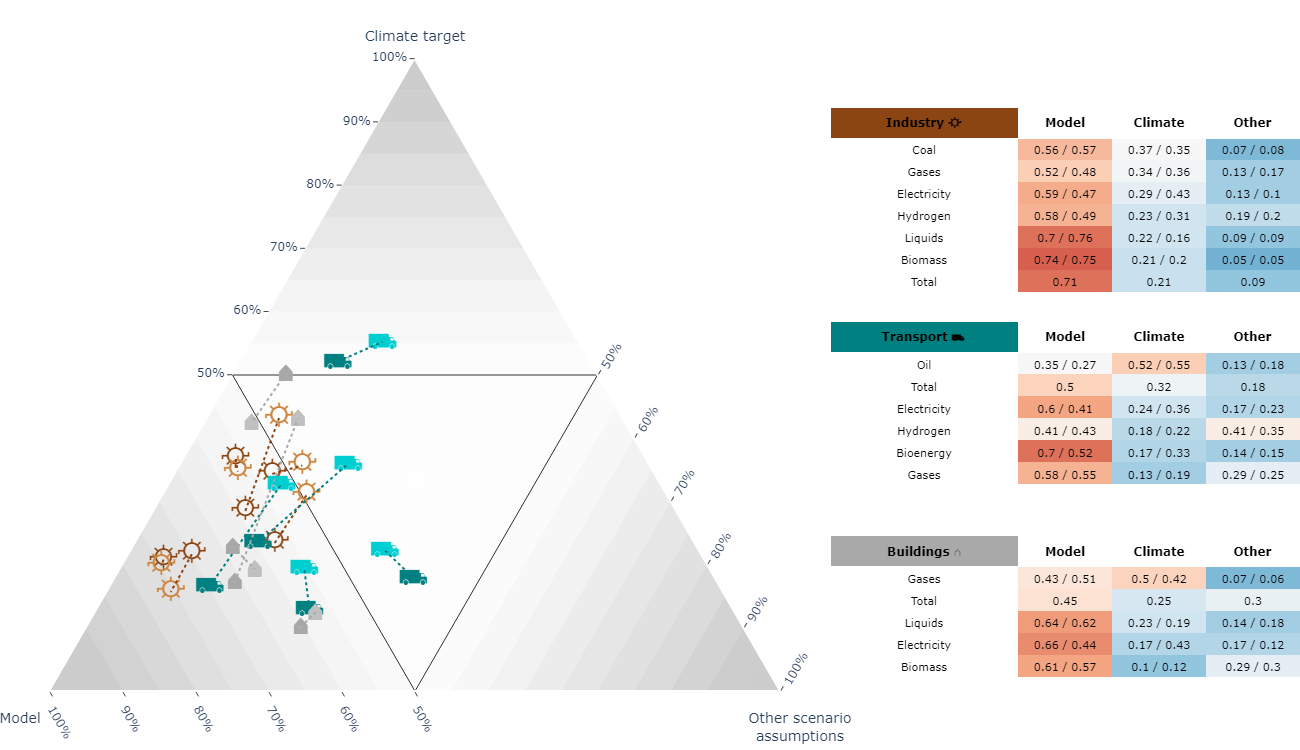

In [21]:
fig = make_subplots(
    rows=7, cols=5,
    horizontal_spacing = 0.04,
    vertical_spacing=0,
    specs = [[{"type": "scatterternary", "colspan": 3, "rowspan": 7}, {}, {}, {}, {}],
             [{}, {}, {}, {"type": "table", "rowspan": 2, "colspan": 2}, {}],
             [{}, {}, {}, {}, {}],
             [{}, {}, {}, {"type": "table", "rowspan": 2, "colspan": 2}, {}],
             [{}, {}, {}, {}, {}],
             [{}, {}, {}, {"type": "table", "rowspan": 2, "colspan": 2}, {}],
             [{}, {}, {}, {}, {}]
            ]
)

# Lines 50%
fig.add_trace(go.Scatterternary(a=[0.5, 0.5, 0, 0.5], b=[0, 0.5, 0.5, 0], c=[0.5, 0, 0.5, 0.5],
                                                mode='lines',
                                                showlegend=False,
                                                hoverinfo='skip',
                                                marker={'size': 15,
                                                        'color': 'black',
                                                        'opacity': 1,#0.9-i*0.03,
                                                        'line' :dict(width=0., color="rgba(89,168,89,1)")},
                                                line={'width': 1, #np.mean(s[i:i+2])*0.5,
                                                        'color': 'black'},
                                                textfont=dict(size=5,
                                                        color='black')), 1, 1)

fig.add_trace(tables[0], 2, 4)
fig.add_trace(tables[1], 4, 4)
fig.add_trace(tables[2], 6, 4)

for n in range(len(conttraces)):
        fig.add_trace(conttraces[n], 1, 1)

for n in range(len(scatters)):
    fig.add_trace(scatters[n], 1, 1)

fig.update_layout(height=750, width=1300)
fig.update_layout({'margin':dict(l=50,r=0,b=0,t=0),
'ternary':
{'sum':1,
'bgcolor':'rgba(0,0,0,0)',
'aaxis':{'title': 'Climate target<br>', 'min': 0, 
        'linewidth':0, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'], 'tickfont':{'size':12}},
'baxis':{'title': 'Model &nbsp; &nbsp;', 'min': 0, 
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':60, 'tickfont':{'size':12}},
'caxis':{'title': 'Other scenario<br>assumptions', 'min': 0, 
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':-60, 'tickfont':{'size':12}}}})

fig.show(renderer='png')

## Savings

In [22]:
if save == 1:
    try:
        os.remove('../Figures/Paperfigures/Figure_S6.html')
    except:
        3
    def html_w(typ):
        return '<html> '+typ+' <p style="font-family: Arial">'
    fig.write_image("../Figures/Paperfigures/Figure_S6.svg")
    today = date.today()
    td = today.strftime("%B %d, %Y")

    with open('../Figures/Paperfigures/Figure_S6.html', 'a') as f:
        f.write(html_w('<h1>')+'Figure - Overview</p></h1>')
        f.write(html_w('<body>')+'Data is for year '+str(timestamp)+'. Version: '+td+'</p></body>')
        f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))